Try to perform Person Identification using a SimCLR architecture with a **ResNet18** as encoder.

In [1]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
from copy import deepcopy
from sklearn.metrics import confusion_matrix

from utils_preprocess import *
from utils_traintest import *
from torch.nn import Module, Sequential, Conv2d, BatchNorm2d, ReLU, MaxPool2d, AvgPool2d, Linear, Dropout, ZeroPad2d, CrossEntropyLoss
from torch.optim import SGD, Adam, AdamW, lr_scheduler
import torchvision
from tqdm import tqdm
#from ResNet18 import ConvolutionalBlock, IdentityBlock
from models import ResNet18 as RN

In [2]:
# Set seeds for reproducibility
# fix this
seed = 203345656
torch.manual_seed(seed)

### Step 1
#### Define classes for encoder 
In pratica questa sezione va eliminata, erchè carichiamo i modelli già allenati dal buon Fede

In [3]:
class Conv2d_rl(Module):
    def __init__(self, in_filters, out_filters, kernel_size, strides, padding):
        super().__init__()
        self.conv = nn.Conv2d(in_filters, out_filters, kernel_size=kernel_size, stride=strides, padding=padding)
        self.relu = nn.ReLU()

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        x = self.conv(x)
        return self.relu(x)
    
class Reduction(Module):

    def __init__(self, in_filters):
        super().__init__()
        self.max_pool = MaxPool2d(kernel_size=2, stride=2, padding=0) #170,50
        self.central_block = Conv2d_rl(in_filters=in_filters, out_filters=5, kernel_size=2, strides=2, padding="valid")
        self.right_block =  Sequential(
            Conv2d_rl(in_filters=in_filters, out_filters=3, kernel_size=1, strides=1, padding="same"), 
            Conv2d_rl(in_filters=3, out_filters=6, kernel_size=2, strides=1, padding="same"),  
            Conv2d_rl(in_filters=6, out_filters=9, kernel_size=4, strides=2, padding=1),
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        x_1 = self.max_pool(x)
        x_2 = self.central_block(x)
        x_3 = self.right_block(x)
        x = torch.cat([x_1, x_2, x_3], axis=1)
        return x
    
class Inception(Module):

    def __init__(self):
        super().__init__()
        self.reductions = Sequential(Reduction(1))
        self.conv = Conv2d_rl(in_filters=15, out_filters=3, kernel_size=1, strides=1, padding="same") # here pad doesnt make much difference
        self.drop = Dropout(0.2)
        self.classification_layer = Linear(25500, 5) #170*50*3 / 10
        self.apply(self._init_weights)

    def forward(self, x):
        x = self.reductions(x)
        x = self.conv(x)
        x = t.flatten(x, start_dim=1) 
        #x = x.reshape(x.shape[0], -1, 2550).mean(axis=1)
        x = self.drop(x)
        y = self.classification_layer(x)
        return y

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()


# TODO: modify the architecture to have a hidden_dimension argument?
class InceptionDouble(Module):

    def __init__(self):
        super().__init__()
        self.reductions = Sequential(Reduction(1),
                                     Reduction(15)) # 85*25
        self.conv = Conv2d_rl(in_filters=29, out_filters=3, kernel_size=1, strides=1, padding="same")
        self.avg = nn.AvgPool2d(kernel_size=2, stride=2)
        #self.drop = Dropout(0.2)
        self.apply(self._init_weights)

    def forward(self, x):
        x = self.reductions(x)
        x = self.conv(x)
        x = self.avg(x)
        x = t.flatten(x, start_dim=1)
        #x = self.drop(x)
        return x

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

In [4]:
"""class SimCLR(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()

        # Base model f(.)
        self.encoder = InceptionDouble() # 6375 o 1512 credo dopo l'avg pooling

        # projection head g(.)
        self.classification_layer = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1512, 4*hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    def forward(self, x):
        feats = self.encoder(x)
        project = self.classification_layer(feats)
        return project
    
##### RESNET18 ######

class ResNet18(Module):

    def __init__(self):
        super().__init__()
        self.network = Sequential(
            # STAGE 1
            Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding='valid'), # DOWNSAMPLING 167*47
            BatchNorm2d(64), # CHECK: MUST BE APPLIED TO THE CHANNEL AXIS
            MaxPool2d(kernel_size=3, stride=2), # DOWNSAMPLING 83*23
            # STAGE 2
            ConvolutionalBlock(64, [64, 64], stride=1), # DOWNSAMPLING 
            IdentityBlock(64, [64, 64]),
            # STAGE 3
            ConvolutionalBlock(64, [128, 128]), # DOWNSAMPLING
            Dropout(0.2),
            IdentityBlock(128, [128, 128]),
            # STAGE 4
            ConvolutionalBlock(128, [256, 256]), # DOWNSAMPLING
            Dropout(0.2),
            IdentityBlock(256, [256, 256]),
            ZeroPad2d((0,1,0,1)), # UPSAMPLING
            # STAGE 5
            ConvolutionalBlock(256, [512, 512]), # DOWNSAMPLING 9*2?
            Dropout(0.2),
            IdentityBlock(512, [512, 512]),

            AvgPool2d(kernel_size=2, stride=2, ceil_mode=True) # DOWNSAMPLING 5*1?
        )
        #self.classification_layer = Linear(512, 5)
        self.apply(self._init_weights)

    def forward(self, x):
        x = self.network(x)
        x = x.reshape(x.shape[0], -1, 512).mean(axis=1) # axis=1 ha size 2560/512 = 5
        # NB: forse si può provare anche senza fare la media alla fine
        #y = self.classification_layer(x)
        return x

    def _init_weights(self, module):
        if isinstance(module, t.nn.Linear):
            t.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, t.nn.Conv2d):
            t.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

class SimCLR18(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()

        # Base model f(.)
        self.encoder = ResNet18()

        # projection head g(.)
        self.classification_layer = nn.Sequential(
            #nn.Dropout(0.2),
            nn.Linear(512, 4*hidden_dim),
            nn.ReLU(inplace=True),
            #nn.Dropout(0.2),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    def forward(self, x):
        feats = self.encoder(x)
        project = self.classification_layer(feats)
        return project
"""

"class SimCLR(nn.Module):\n    def __init__(self, hidden_dim):\n        super().__init__()\n\n        # Base model f(.)\n        self.encoder = InceptionDouble() # 6375 o 1512 credo dopo l'avg pooling\n\n        # projection head g(.)\n        self.classification_layer = nn.Sequential(\n            nn.Dropout(0.2),\n            nn.Linear(1512, 4*hidden_dim),\n            nn.ReLU(inplace=True),\n            nn.Dropout(0.2),\n            nn.Linear(4*hidden_dim, hidden_dim)\n        )\n\n    def forward(self, x):\n        feats = self.encoder(x)\n        project = self.classification_layer(feats)\n        return project\n    \n##### RESNET18 ######\n\nclass ResNet18(Module):\n\n    def __init__(self):\n        super().__init__()\n        self.network = Sequential(\n            # STAGE 1\n            Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding='valid'), # DOWNSAMPLING 167*47\n            BatchNorm2d(64), # CHECK: MUST BE APPLIED TO THE CHANNEL AXIS\n            

In [11]:
dir_init = './doppler_traces/' #Directory of data
subdirs_init = 'S1a,S1b,S1c' #Subdirs for training

In [12]:
transforms = DopplerTransformations()

dataset_csi_train = create_training_set(dir_init=dir_init, subdirs_init=subdirs_init, transform=transforms)
dataset_csi_val = create_validation_set(dir_init=dir_init, subdirs_init=subdirs_init, transform=transforms)
dataset_csi_test, labels_true_test = create_test_set(dir_init=dir_init, subdirs_init=subdirs_init, transform=transforms)

In [36]:
print(labels_true_test)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

### Step 1
#### Train the encoder (Reduction)
**This can be either done with self-supervised contrastive, or with supervised contrastive**

In [ ]:
# Define training hyperparameters
batch_size=128
hidden_dim=128
temperature=0.07
weight_decay=1e-4
max_epochs=500
lr=2e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

epochs = 100

#path to the folder where pretrained models are saved
CHECKPOINT_PATH = "./saved_models"


# Define SimCLR Model
simclr_model = SimCLR18(hidden_dim)

# Define Optimizer and Learning rate Scheduler
optimizer = AdamW(simclr_model.parameters(), lr=lr, weight_decay=weight_decay)
my_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max = max_epochs, eta_min=lr/50)

# Training Loop
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    # Training iterations and update lists
    train_loss, train_top1_acc = train_contrastive_self(simclr_model, device, dataset_csi_train, optimizer, my_lr_scheduler, epoch, loss_temperature=temperature)
    train_losses.append(train_loss)
    train_accs.append(train_top1_acc)

    # Validation iterations
    val_loss, val_top1_acc = valid_constrastive_self(simclr_model, device, dataset_csi_val, epoch, loss_temperature=temperature)
    val_losses.append(val_loss)
    val_accs.append(val_top1_acc)

    if epoch%10 == 0:
        # Save the model
        torch.save(simclr_model.state_dict(), os.path.join(CHECKPOINT_PATH, 'My_SimCLR.ckpt'))
        # saves the curves
        csv_file_path = os.path.join(CHECKPOINT_PATH, 'training_metrics.csv')
        # Write the lists to a CSV file
        with open(csv_file_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Epoch', 'Train Loss', 'Validation Loss', 'Train Top-5 Accuracy', 'Validation Top-5 Accuracy'])
            for epoch in range(epochs):
                writer.writerow([epoch + 1, train_losses[epoch], val_losses[epoch], train_accs[epoch], val_accs[epoch]])
        
        print(f"Training metrics saved to {csv_file_path}")

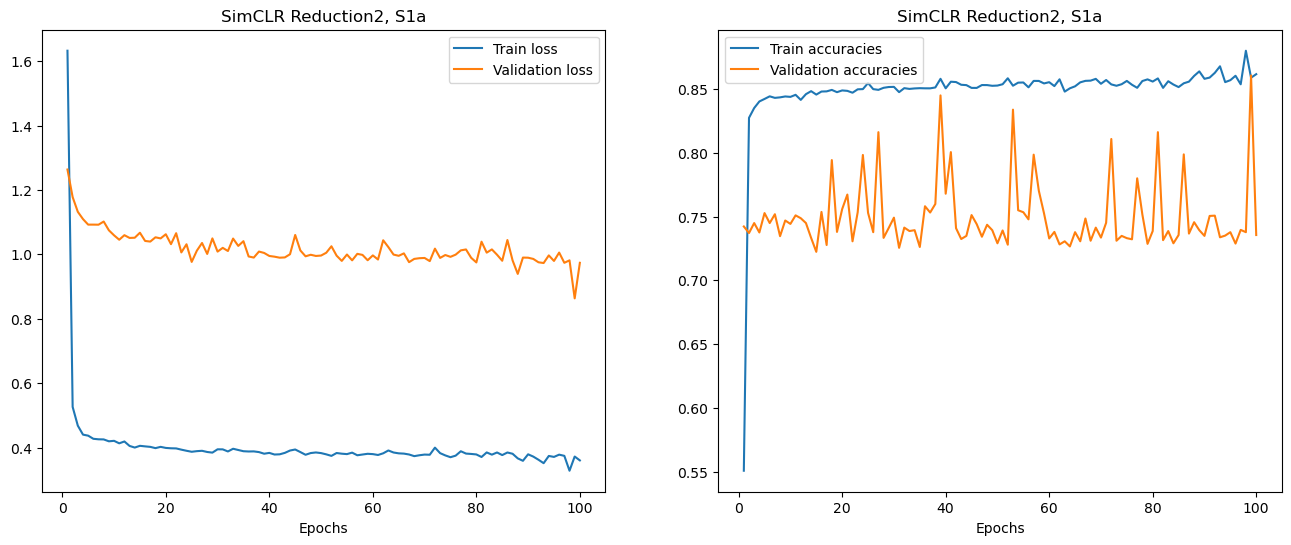

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(np.arange(1, 101), train_losses, label="Train loss")
ax1.plot(np.arange(1, 101), val_losses, label="Validation loss")
ax1.set_xlabel("Epochs")
ax1.set_title("SimCLR Reduction2, S1a")
ax1.legend()
ax2.plot(np.arange(1,101), train_accs, label="Train accuracy")
ax2.plot(np.arange(1,101), val_accs, label="Validation accuracy")
ax2.set_xlabel("Epochs")
ax2.set_title("SimCLR Reduction2, S1a")
ax2.legend()

### Step 2

#### Train the 1st classifier
Load the model from Fede \
Use the cross entropy loss

In [5]:
# Save the encoder
#torch.save(simclr_model.state_dict(), os.path.join(CHECKPOINT_PATH, 'My_SimCLR.ckpt'))
simclr_model = RN.ResNet18(hidden_dimension=16)

# Load the trained encoder here
path_model = 'models/ResNet18/My_ResNet18_hd16_bs128.ckpt'
simclr_model.load_state_dict(torch.load(path_model, map_location=torch.device('cpu'), weights_only=True))#["state_dict"])

<All keys matched successfully>

In [6]:
simclr_model

ResNet18(
  (network): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=valid)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ConvolutionalBlock(
      (main_path): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
      (shortcut_path): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): IdentityBlock(
      (main_path): Sequential(
        (

In [7]:
class SimpleClassifier(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super().__init__()

        # Mapping from representation h to classes with a linear layer
        self.model = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [8]:
# encode the input data (train, test & validation) with the trained representation
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
dir_init = './doppler_traces/' #Directory of data
subdirs_init = 'S1a' #Subdirs for training

dataset_csi_train_class = create_training_set(dir_init=dir_init, subdirs_init=subdirs_init)
dataset_csi_val_class = create_validation_set(dir_init=dir_init, subdirs_init=subdirs_init)

train_feats = prepare_data_features(simclr_model, dataset_csi_train_class)
val_feats = prepare_data_features(simclr_model, dataset_csi_val_class)

  0%|          | 0/226 [00:00<?, ?it/s]

100%|██████████| 70/70 [00:36<00:00,  1.94it/s]


In [10]:
feats, labels = train_feats.tensors  # Accedi ai tensori contenuti nel TensorDataset
print(feats.shape)
print(labels.shape)

torch.Size([7220, 2560])
torch.Size([7220, 1])


In [10]:
batch_size=64
num_classes=5
lr=1e-3
weight_decay=1e-3
har_projection_head = SimpleClassifier(2560, num_classes=5)
opt = AdamW(har_projection_head.parameters(), lr=lr, weight_decay=weight_decay)
checkpoint_path = 'models/ResNet18/projection_heads'
save_name='SimpleClassifier_HAR_hd16_bs128.ckpt'

train_losses, train_accs, val_losses, val_accs = train_projection(model=har_projection_head, optimizer=opt, train_feats_data=train_feats, val_feats_data=val_feats, checkpoint_path=checkpoint_path, save_name=save_name, device="cpu", batch_size=batch_size, epochs=25)

NameError: name 'train_feats' is not defined

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(np.arange(1, 101), train_losses, label="Train loss")
ax1.plot(np.arange(1, 101), val_losses, label="Validation loss")
ax1.set_xlabel("Epochs")
ax1.set_title("SimpleClassifier_HAR_hd16_bs128, S1a")
ax1.legend()
ax2.plot(np.arange(1,101), train_accs, label="Train accuracy")
ax2.plot(np.arange(1,101), val_accs, label="Validation accuracy")
ax2.set_xlabel("Epochs")
ax2.set_title("SimpleClassifier_HAR_hd16_bs128, S1a")
ax2.legend()

#### Test the 1st classifier
First on the same dataset as that of training

In [19]:
# prepare the test set for the classifier
dir_init = './doppler_traces/' #Directory of data
subdirs_init = 'S1a' #Subdirs for training

dataset_csi_test_class, labels_true_test = create_test_set(dir_init=dir_init, subdirs_init=subdirs_init)
test_feats = prepare_data_features(simclr_model, dataset_csi_test_class)

labels_considered = np.arange(5)

NameError: name 'prepare_data_features' is not defined

In [20]:
# define a classifier object
classifier_model = SimpleClassifier(2560, num_classes=5)

# Load the trained projection head here
path_model = 'models/ResNet18/projection_heads/SimpleClassifier_HAR_hd16_bs128.ckpt'
classifier_model.load_state_dict(torch.load(path_model, map_location=torch.device('cpu'), weights_only=True))#["state_dict"])

<All keys matched successfully>

In [21]:
# test the projection head on the test set:
# start from the input test set, extract the feature representation via the encoder

device = 'cuda' if torch.cuda.is_available() else 'cpu'
classifier_model.to(device)
classifier_model.eval()
batch_size = 64
loss_fn = CrossEntropyLoss()

with torch.no_grad():
    predictions = []
    true = []

    test_loader = DataLoader(test_feats, batch_size=batch_size, shuffle=False, drop_last=False)

    for batch in tqdm(test_loader):
        feats, labels = batch
        feats = feats.to(device)
        labels = labels.to(device)
        labels = labels.squeeze(dim=1)
        preds = classifier_model(feats)
        predictions.append(preds)
        true.append(labels)

    predictions = torch.cat(predictions, axis=0) # concatenate the predictions for all batches
    true = torch.cat(true, axis=0)
    print("shape of the predicted labels list:", predictions.shape)
    print("shape of the true labels:", true.shape)
    test_loss = loss_fn(predictions, true) # ok ma è più importante l'accuracy
    true = true.detach().cpu()
    labels_pred_list_test = torch.softmax(predictions, dim=1).detach().cpu()
    labels_pred_test = labels_pred_list_test.argmax(dim=1) # restituisce l'indice del valore maggiore
    test_acc = (labels_pred_test == true).float().mean()
    conf_matrix = confusion_matrix(true, labels_pred_test)

    #precision, recall, fscore, _ = precision_recall_fscore_support(true,labels_pred_test,labels=labels_considered) # non credo ci serva

    #accuracy = accuracy_score(true, labels_pred_test) # stessa cosa di test accuracy
    #if true in argsort[:N] per top-N score?
    #print(f"loss: {test_loss}, accuracy: {test_acc}")
    print(f"loss: {test_loss}, accuracy: {test_acc}")

100%|██████████| 35/35 [00:00<00:00, 553.65it/s]

shape of the predicted labels list: torch.Size([2188, 5])
shape of the true labels: torch.Size([2188])
loss: 0.3393916189670563, accuracy: 0.8587751388549805


/home/giovanni/Desktop/Deep Learning/project/NNDL HAR project/utils_traintest.py:253: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(name_fig)
/home/giovanni/miniconda3/envs/dlproject/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


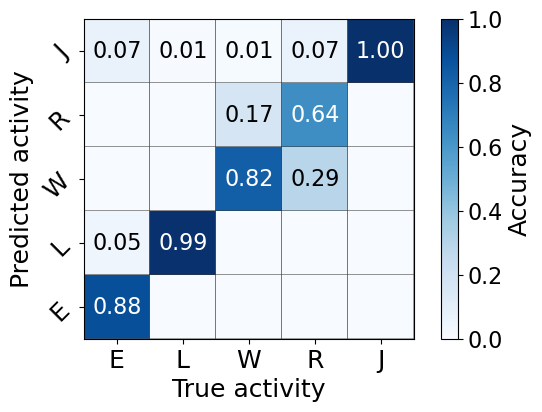

In [30]:
activities = np.array(['E','L','W','R','J'])
name_plot = "SimpleClassifier_HAR_hd16_bs128"

# plot the confusion matrix
plt_confusion_matrix(activities.shape[0], conf_matrix, activities=activities, name_save=name_plot)

In [31]:
print(len(labels_true_test)) # true labels (not expanded)
print(labels_pred_list_test) 
print(len(labels_pred_test)) # predicted labels (expanded; it's the argmax of labels_prediction_list_test)

547
tensor([[9.9998e-01, 2.1176e-05, 1.8790e-29, 3.0739e-24, 7.9661e-22],
        [9.9999e-01, 1.2855e-05, 1.0786e-29, 1.4653e-24, 3.0666e-22],
        [9.9955e-01, 6.0408e-06, 2.0069e-04, 2.2317e-04, 2.0544e-05],
        ...,
        [2.2904e-06, 7.0438e-10, 8.4648e-01, 1.5351e-01, 6.3275e-06],
        [8.4366e-07, 2.6255e-09, 8.2108e-02, 9.1483e-01, 3.0633e-03],
        [8.8441e-05, 5.8046e-10, 9.3552e-01, 6.4353e-02, 3.9948e-05]])
2188


Merge the predictions from the various antennas

In [39]:
csi_act = 'E,L,W,R,J'
subdirs_training = 'S1a'
bandwidth = 80
sub_band = 1
suffix = '.txt'

labels_pred_max_merged = merge_predictions(labels_true_test, labels_pred_list_test, labels_pred_test)

conf_matrix_max_merged = confusion_matrix(labels_true_test, labels_pred_max_merged, labels=labels_considered)

activities = np.array(['E','L','W','R','J'])
name_plot = "SimpleClassifier_HAR_hd16_bs128_merged"

plt_confusion_matrix(activities.shape[0], conf_matrix_max_merged, activities=activities, name_save=name_plot)

#precision_max_merge, recall_max_merge, fscore_max_merge, _ = \
#    precision_recall_fscore_support(labels_true_merge, pred_max_merge, labels=labels_considered)
#accuracy_max_merge = accuracy_score(labels_true_merge, pred_max_merge)

metrics_matrix_dict = {'conf_matrix': conf_matrix,
                        #'accuracy_single': accuracy,
                        #'precision_single': precision,
                        #'recall_single': recall,
                        #'fscore_single': fscore,
                        'conf_matrix_max_merge': conf_matrix_max_merged,
                        #'accuracy_max_merge': accuracy_max_merge,
                        #'precision_max_merge': precision_max_merge,
                        #'recall_max_merge': recall_max_merge,
                        #'fscore_max_merge': fscore_max_merge
                        }

if not os.path.exists('outputs'):
    os.makedirs('outputs')
name_file = './outputs/test_' + str(csi_act) + '_' + subdirs_training + '_band_' + str(bandwidth) + '_subband_' + \
        str(sub_band) + suffix
with open(name_file, "wb") as fp:  # Pickling
    pickle.dump(metrics_matrix_dict, fp)

NameError: name 'merge_predictions' is not defined

In [ ]:
# questa roba per me possiamo saltarla

# impact of the number of antennas
one_antenna = [[0], [1], [2], [3]]
two_antennas = [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]
three_antennas = [[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]
four_antennas = [[0, 1, 2, 3]]
seq_ant_list = [one_antenna, two_antennas, three_antennas, four_antennas]
average_accuracy_change_num_ant = np.zeros((num_antennas,))
average_fscore_change_num_ant = np.zeros((num_antennas,))
labels_true_merge = np.array(labels_test_selected)
for ant_n in range(num_antennas):
    seq_ant = seq_ant_list[ant_n]
    num_seq = len(seq_ant)
    for seq_n in range(num_seq):
        pred_max_merge = np.zeros((len(labels_test_selected),))
        ants_selected = seq_ant[seq_n]
        for i_lab in range(len(labels_test_selected)):
            pred_antennas = labels_prediction_list_test[i_lab * num_antennas:(i_lab + 1) * num_antennas, :].numpy()
            pred_antennas = pred_antennas[ants_selected, :]

            lab_merge_max = np.argmax(np.sum(pred_antennas, axis=0))

            pred_max_antennas = labels_pred_test[i_lab * num_antennas:(i_lab + 1) * num_antennas]
            pred_max_antennas = pred_max_antennas[ants_selected]
            lab_unique, count = np.unique(pred_max_antennas, return_counts=True)
            lab_max_merge = -1
            if len(lab_unique) > 1:
                count_argsort = np.flip(np.argsort(count))
                count_sort = count[count_argsort]
                lab_unique_sort = lab_unique[count_argsort]
                if count_sort[0] == count_sort[1] or len(lab_unique) > ant_n - 1:  # ex aequo between two labels
                    lab_max_merge = lab_merge_max
                else:
                    lab_max_merge = lab_unique_sort[0]
            else:
                lab_max_merge = lab_unique[0]
            pred_max_merge[i_lab] = lab_max_merge

        _, _, fscore_max_merge, _ = precision_recall_fscore_support(labels_true_merge, pred_max_merge,
                                                                    labels=[0, 1, 2, 3, 4])
        accuracy_max_merge = accuracy_score(labels_true_merge, pred_max_merge)

        average_accuracy_change_num_ant[ant_n] += accuracy_max_merge
        average_fscore_change_num_ant[ant_n] += np.mean(fscore_max_merge)

    average_accuracy_change_num_ant[ant_n] = average_accuracy_change_num_ant[ant_n] / num_seq
    average_fscore_change_num_ant[ant_n] = average_fscore_change_num_ant[ant_n] / num_seq

metrics_matrix_dict = {'average_accuracy_change_num_ant': average_accuracy_change_num_ant,
                        'average_fscore_change_num_ant': average_fscore_change_num_ant}

name_file = './outputs/change_number_antennas_test_' + str(csi_act) + '_' + subdirs_training + '_band_' + \
            str(bandwidth) + '_subband_' + str(sub_band) + '.txt'
with open(name_file, "wb") as fp:  # Pickling
    pickle.dump(metrics_matrix_dict, fp)


#### Train the 2nd classifier

Now we train the second projection head, used for person identification.\
Our dataset has 3 different "people" features. We need to labels data according to the person it refers to, and then to train the projection head on these.\
The dataset are divided as follows: 
- S1, S2, S4, S6 -> P1
- S3, S5 -> P2
- S7 -> P3


#### Test the 2nd classifier

## Ratatuja

In [7]:
device = 'cpu'
model = SimCLR(128)

for i, batch in enumerate(dataset_csi_train):
    batch_x, batch_y = batch
    print('start shape:',batch_x.shape)

    # Here the input is different from the self supervised case: batch_x is not a list of two,
    # rather a unique tensor with four channels. Therefore it has to be reshaped 
    # TO BE CHECKED
    
    batch_x_resh = batch_x.reshape(-1, 1, 340, 100)
    print('after reshaping:', batch_x_resh.shape)

    if i>= 3: break

    # Compute the features
    #features = model(cat_imgs)

start shape: torch.Size([32, 4, 340, 100])
after reshaping: torch.Size([128, 1, 340, 100])
start shape: torch.Size([32, 4, 340, 100])
after reshaping: torch.Size([128, 1, 340, 100])
start shape: torch.Size([32, 4, 340, 100])
after reshaping: torch.Size([128, 1, 340, 100])
start shape: torch.Size([32, 4, 340, 100])
after reshaping: torch.Size([128, 1, 340, 100])


In [25]:
import torch
import torch.nn.functional as F

# Example feature batch
# 4*3
features_batch = torch.tensor([[1.0, 0.0, 0.0],
                               [0.0, 1.0, 0.0],
                               [0.0, 0.0, 1.0],
                               [1.0, 1.0, 0.0]])

temperature = 0.5

# Compute Cosine Similarity
cos_sim = F.cosine_similarity(features_batch[:, None, :], features_batch[None, :, :], dim=-1)
print("Cosine Similarity Matrix:")
print(cos_sim)

# Mask out cosine similarity to itself
self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
cos_sim.masked_fill_(self_mask, -9e15)
print("\nCosine Similarity Matrix after Masking Self-Similarity:")
print(cos_sim)

# Find the positive example mask
pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
print("\nPositive Example Mask:")
print(pos_mask)

# NT_Xent loss
cos_sim = cos_sim / temperature
nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
#nll = nll.mean()
print("\nNegative Log-Likelihood (NLL) Loss:")
print(nll)

# Get ranking position of positive example
# for a perfect classification the ranking of the positives is 0
comb_sim = torch.cat([cos_sim[pos_mask][:, None], cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
print("\nRanking Position of Positive Example:")
print(sim_argsort)

acc_top1 = (sim_argsort == 0).float().mean()
acc_top5 = (sim_argsort < 5).float().mean()
print("\nTop-1 Accuracy:")
print(acc_top1)
print("\nTop-5 Accuracy:")
print(acc_top5)

Cosine Similarity Matrix:
tensor([[1.0000, 0.0000, 0.0000, 0.7071],
        [0.0000, 1.0000, 0.0000, 0.7071],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.7071, 0.7071, 0.0000, 1.0000]])

Cosine Similarity Matrix after Masking Self-Similarity:
tensor([[-9.0000e+15,  0.0000e+00,  0.0000e+00,  7.0711e-01],
        [ 0.0000e+00, -9.0000e+15,  0.0000e+00,  7.0711e-01],
        [ 0.0000e+00,  0.0000e+00, -9.0000e+15,  0.0000e+00],
        [ 7.0711e-01,  7.0711e-01,  0.0000e+00, -9.0000e+15]])

Positive Example Mask:
tensor([[False, False,  True, False],
        [False, False, False,  True],
        [ True, False, False, False],
        [False,  True, False, False]])

Negative Log-Likelihood (NLL) Loss:
tensor([1.8105, 0.3962, 1.0986, 0.8079])

Ranking Position of Positive Example:
tensor([1, 0, 0, 0])

Top-1 Accuracy:
tensor(0.7500)

Top-5 Accuracy:
tensor(1.)


In [28]:
sim_argsort == 0

tensor([False,  True,  True,  True])

In [60]:
print(cos_sim)
print(pos_mask)
print(cos_sim[pos_mask])
print(cos_sim[pos_mask][:, None])
t.logsumexp(cos_sim, dim=0)

tensor([[-1.8000e+16,  0.0000e+00,  0.0000e+00,  1.4142e+00],
        [ 0.0000e+00, -1.8000e+16,  0.0000e+00,  1.4142e+00],
        [ 0.0000e+00,  0.0000e+00, -1.8000e+16,  0.0000e+00],
        [ 1.4142e+00,  1.4142e+00,  0.0000e+00, -1.8000e+16]])
tensor([[False, False,  True, False],
        [False, False, False,  True],
        [ True, False, False, False],
        [False,  True, False, False]])
tensor([0.0000, 1.4142, 0.0000, 1.4142])
tensor([[0.0000],
        [1.4142],
        [0.0000],
        [1.4142]])


tensor([1.8105, 1.8105, 1.0986, 2.2221])

In [64]:
comb_sim = torch.cat([cos_sim[pos_mask][:, None], cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
print(comb_sim)
sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
print(comb_sim.argsort(dim=-1, descending=True))
print("\nRanking Position of Positive Example:")
print(sim_argsort)

acc_top1 = (sim_argsort == 0).float().mean()
acc_top5 = (sim_argsort < 5).float().mean()
print("\nTop-1 Accuracy:")
print(acc_top1)
print("\nTop-5 Accuracy:")
print(acc_top5)

# sostanzialmente vogliamo vedere se gli elementi della colonna stanno dove sono!

tensor([[ 0.0000e+00, -1.8000e+16,  0.0000e+00, -9.0000e+15,  1.4142e+00],
        [ 1.4142e+00,  0.0000e+00, -1.8000e+16,  0.0000e+00, -9.0000e+15],
        [ 0.0000e+00, -9.0000e+15,  0.0000e+00, -1.8000e+16,  0.0000e+00],
        [ 1.4142e+00,  1.4142e+00, -9.0000e+15,  0.0000e+00, -1.8000e+16]])
tensor([[4, 0, 2, 3, 1],
        [0, 1, 3, 4, 2],
        [0, 2, 4, 1, 3],
        [0, 1, 3, 2, 4]])

Ranking Position of Positive Example:
tensor([1, 0, 0, 0])

Top-1 Accuracy:
tensor(0.7500)

Top-5 Accuracy:
tensor(1.)


Come si generalizza al caso di più positive keys?

In [24]:
trial = torch.randn(8, 8)

self_mask = torch.eye(trial.shape[0], dtype=torch.bool)
trial.masked_fill_(self_mask, -9e15)
print("\nCosine Similarity Matrix after Masking Self-Similarity:")
print(trial)

batch_size = self_mask.shape[0] // 4
for i in range(1, 4):
    pos_mask |= self_mask.roll(shifts=batch_size * i, dims=0)
print("\nPositive Example Mask:")
print(pos_mask)


Cosine Similarity Matrix after Masking Self-Similarity:
tensor([[-9.0000e+15, -1.4598e+00, -2.8293e-01,  1.0803e+00,  1.3399e-01,
         -2.8742e-01, -7.2608e-01,  1.1453e+00],
        [-1.5653e+00, -9.0000e+15,  9.2967e-01,  3.2157e-01,  2.5125e-01,
          1.2050e+00, -6.5705e-01,  1.9692e+00],
        [-1.0314e+00,  3.8276e-02, -9.0000e+15,  6.5880e-02, -5.8850e-01,
         -7.0798e-01,  5.4116e-01, -2.5975e-01],
        [ 8.1121e-01,  2.0937e-01, -2.6811e-02, -9.0000e+15,  8.6760e-02,
         -9.6729e-01,  6.7711e-01,  3.1482e-01],
        [ 1.3140e+00, -1.9555e-01,  1.3681e+00, -1.2858e+00, -9.0000e+15,
          9.6381e-01,  7.1739e-01,  5.0893e-01],
        [-1.1161e+00,  6.0131e-01,  6.3219e-02,  8.1579e-01, -8.3342e-01,
         -9.0000e+15, -2.9551e-02,  5.2883e-01],
        [-1.0231e+00, -1.6313e+00, -7.5080e-01, -4.4043e-01, -1.3270e+00,
          7.3080e-01, -9.0000e+15,  7.9917e-01],
        [ 2.3706e+00,  8.6014e-01, -8.7056e-01,  3.6237e-01,  2.5977e-01,
        

In [78]:
#print(trial[pos_mask].reshape(-1,3))

comb_sim = torch.cat([trial[pos_mask].reshape(-1,3), trial.masked_fill(pos_mask, -9e15)], dim=-1)
print(comb_sim)
sim_argsort = comb_sim.argsort(dim=-1, descending=True)
print(sim_argsort)
inx0 = sim_argsort.argmin(dim=-1)
inx0 = torch.tensor([np.where(row == 0)[0][0] for row in sim_argsort])
inx1 = torch.tensor([np.where(row == 1)[0][0] for row in sim_argsort]) # we need the 0,0 because it returns a tuple
inx2 = torch.tensor([np.where(row == 2)[0][0] for row in sim_argsort]) # we need the 0,0 because it returns a tuple
print(inx0, "\n", inx1, "\n", inx2)

print("\nRanking Position of Positive1 Example:")
print(inx0)

tensor([[-2.8293e-01,  1.3399e-01, -7.2608e-01, -9.0000e+15, -1.4598e+00,
         -9.0000e+15,  1.0803e+00, -9.0000e+15, -2.8742e-01, -9.0000e+15,
          1.1453e+00],
        [ 3.2157e-01,  1.2050e+00,  1.9692e+00, -1.5653e+00, -9.0000e+15,
          9.2967e-01, -9.0000e+15,  2.5125e-01, -9.0000e+15, -6.5705e-01,
         -9.0000e+15],
        [-1.0314e+00, -5.8850e-01,  5.4116e-01, -9.0000e+15,  3.8276e-02,
         -9.0000e+15,  6.5880e-02, -9.0000e+15, -7.0798e-01, -9.0000e+15,
         -2.5975e-01],
        [ 2.0937e-01, -9.6729e-01,  3.1482e-01,  8.1121e-01, -9.0000e+15,
         -2.6811e-02, -9.0000e+15,  8.6760e-02, -9.0000e+15,  6.7711e-01,
         -9.0000e+15],
        [ 1.3140e+00,  1.3681e+00,  7.1739e-01, -9.0000e+15, -1.9555e-01,
         -9.0000e+15, -1.2858e+00, -9.0000e+15,  9.6381e-01, -9.0000e+15,
          5.0893e-01],
        [ 6.0131e-01,  8.1579e-01,  5.2883e-01, -1.1161e+00, -9.0000e+15,
          6.3219e-02, -9.0000e+15, -8.3342e-01, -9.0000e+15, -2.9551e-0

In [71]:
test = np.array([[2,  1,  5,  0,  7,  9,  3,  4,  6,  8, 10],[1,  0,  5,  5,  2,  3,  3,  4,  6,  8, 10]])

inx1 = np.array([np.where(row == 1)[0][0] for row in test]) # we need the 0,0 because it returns a tuple
print(inx1)

[1 0]


In [67]:
test2 = np.array([2,  1,  5,  0,  7,  9,  3,  4,  6,  8, 10])
idx1 = np.where(test2 == 10)
idx1[0][0]

10

In [82]:
# stack the tensors along a new dimension
pos_indices = torch.stack((inx0, inx1, inx2), dim=-1)
print(pos_indices)

tensor([[3, 2, 5],
        [3, 1, 0],
        [6, 4, 0],
        [3, 6, 2],
        [1, 0, 3],
        [1, 0, 2],
        [4, 3, 5],
        [1, 2, 5]])


In [99]:
# check if the positions of the positive indices are among the first three
pos_idx = np.array([[0,2,1],[1,2,3],[1,2,4]])

# Define the target set
target_set = torch.tensor({0, 1, 2})

# Check each row in the array
results = np.array([set(row) == target_set for row in pos_idx])

# Print the results
print(torch.tensor(results).float().mean())

RuntimeError: Could not infer dtype of set

In [98]:
pos_indices = pos_indices

tensor([3, 2, 5])

In [90]:
set(pos_indices[-3]) == target_set

TypeError: 'builtin_function_or_method' object is not iterable

In [108]:
target_set = {0,1,2}
print(target_set)
a = torch.tensor([0,2,1]).tolist()
print(set(a))

set(a) == target_set

{0, 1, 2}
{0, 1, 2}


True

In [114]:
print(pos_indices)
print(target_set)

n_pos_indices = pos_indices.numpy() # dont know if it is necessary to move this to cpu
print(n_pos_indices)
# Check each row in the array
results2 = [set(row) == target_set for row in n_pos_indices]

# Print the results
print(torch.tensor(results2))

tensor([[3, 2, 5],
        [3, 1, 0],
        [6, 4, 0],
        [3, 6, 2],
        [1, 0, 3],
        [1, 0, 2],
        [4, 3, 5],
        [1, 2, 5]])
{0, 1, 2}
[[3 2 5]
 [3 1 0]
 [6 4 0]
 [3 6 2]
 [1 0 3]
 [1 0 2]
 [4 3 5]
 [1 2 5]]
tensor([False, False, False, False, False,  True, False, False])
